# Homework 4: Data Transformation and Machine Learning

## Part 1: Introduction

March is special, and it's not because it signals the arrival of spring, or because the 17th is St. Patrick's Day. Instead, March plays host to the College Basketball Playoffs, also known as the NCAA Tournament, or March Madness. Every year, millions of Americans fill out their brackets with the hope that it will be the million dollar winner, the one that will perfectly predict all 67 games perfectly in the tournament. While you may not perfectly predict all the matchups, the hope is that this homework will allow you to create a bracket that is better than all of your friends!

For some background on March Madness, click here https://www.youtube.com/watch?v=BLDb8sK95PE&ab_channel=MarchMadness!

To see where we retrieved the data and for more information about what the datasets each mean as well as the columns, click here: https://www.kaggle.com/competitions/march-machine-learning-mania-2023

Our strategy for this homework will be simple. We will use the data and statistics we get from how teams perform throughout the regular season and use that to predict how well the teams will matchup in the post season (March Madness).

As some notes, be sure to use vectorization and native operations as much as possible. For example, if you want to take the summation of a list, use numpy's sum instead of for loop. If you want to conditionally query, use numpy's where or boolean indexing. This will make your code run faster and more efficient. We will be watching for this, though it will be very few points for doing it manually.

These test cases are not at all comprehensive, but they serve more so as a sanity check that your code is working as expected. It is up to you to ensure that your code is correct and can pass the autograder.


In [2]:
# imports (create a venv or pip install everything globall)
# we recommend making a venv for the sake of practice
# if you are on colab.research.google.com, use %pip install {package name} in a separate cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

## Part 2: Data Wrangling

Just like data scientists usually do, you will start with a multitude of raw datasets about Regular Season and March Madness data from 2003 to 2022. Your goal will be to aggregate the data into 2 final datasets that we can use for analysis: one for the regular season and one for the postseason.


Start by reading in the Regular Season data (MRegularSeasonDetailedResults.csv) into a pandas dataframe called regular_season_raw_df. Each row in this dataset corresponds to one regular season game that occurred between 2003 and 2022.


In [3]:
regular_season_raw_df = pd.read_csv("MRegularSeasonDetailedResults.csv")

In [4]:
# Test Case #1
test1_df = regular_season_raw_df.sort_values(by=['WTeamID', 'LTeamID', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test1_df.iloc[0]
if first_row['DayNum'] == 37:
    print('Test Case #1 Passed')
else:
    print('Test Case #1 Failed')

Test Case #1 Passed


Now let's do the same for the March Madness data (MNCAATourneyDetailedResults.csv) and store the data in a pandas dataframe called march_madness_raw_df. Each row in this dataset corresponds to one march madness game that occurred between 2003 and 2022.


In [5]:
march_madness_raw_df = pd.read_csv("MNCAATourneyDetailedResults.csv")

In [8]:
# Test Case #2
test2_df = march_madness_raw_df.sort_values(by=['WTeamID', 'LTeamID', 'Season']).reset_index(drop=True)
first_row = test2_df.iloc[0]
if first_row['DayNum'] == 138:
    print('Test Case #2 Passed')
else:
    print('Test Case #2 Failed')

Test Case #2 Passed


We notice that we have quite a few rows in both datasets that may not be useful to us. For example, since we are only interested in predicting the outcomes of teams in the 2022 March Madness Tournament, we first want to eliminate all teams in the 2 datasets that did not partake in the 2022 March Madness Tournament.


To do this we will first load in the seeds from all the tournaments into tourney_seeds_df, from MNCAATourneySeeds.csv


In [6]:
tourney_seeds_df = pd.read_csv("MNCAATourneySeeds.csv")

Next we will filter this table, to find all of the teams that partook in the 2022 March Madness Tournament. So filter the table to only include the rows where the season is 2022. Store this in a new dataframe called tourney_seeds_2022_df.


In [7]:
tourney_seeds_2022_df = tourney_seeds_df[tourney_seeds_df["Season"] == 2022]

Now that we have a list of all of the teams that partook in the 2022 tournament, we can filter our regular_season_raw_df and our march_madness_raw_df to only include teams who partook in the 2022 March Madness Tournament


In [8]:
regular_season_only_2022_teams_df = regular_season_raw_df[regular_season_raw_df["WTeamID"].isin(tourney_seeds_2022_df["TeamID"]) | regular_season_raw_df["LTeamID"].isin(tourney_seeds_2022_df["TeamID"])]
march_madness_only_2022_teams_df = march_madness_raw_df[march_madness_raw_df["WTeamID"].isin(tourney_seeds_2022_df["TeamID"]) | march_madness_raw_df["LTeamID"].isin(tourney_seeds_2022_df["TeamID"])]

In [9]:
# Test Case #3
if len(regular_season_only_2022_teams_df) == 37698:
    print('Test Case #3 Passed')
else:
    print('Test Case #3 Failed')

Test Case #3 Passed


In [10]:
# Test Case #4
if len(march_madness_only_2022_teams_df) == 903:
    print('Test Case #4 Passed')
else:
    print('Test Case #4 Failed')

Test Case #4 Passed


regular_season_only_2022_teams_df and march_madness_only_2022_teams_df both have WTeamID and LTeamID as columns which signifies the winner and losing team of the corresponding games in the dataset. However, it may be useful to also know what the name of the team was for visual purposes.


To do this, we will have to load in MTeams.csv into teams_df


In [11]:
teams_df = pd.read_csv("MTeams.csv")

Filter teams_df to only include the columns: TeamID and TeamName


In [12]:
filtered_teams_df = teams_df[["TeamID", "TeamName"]]

In [13]:
# Test Case #5
if len(filtered_teams_df.columns) == 2:
    print('Test Case #5 Passed')
else:
    print('Test Case #5 Failed')

Test Case #5 Passed


Now merge filtered_teams_df and regular_season_only_2022_teams_df to add LTeamName and WTeamName to the regular season dataset, calling the new dataframe regular_season_with_teams_df. When doing merges in this homework, use the merge function from pandas which by default does an inner join (feel free to specify inner).

Hint: Might be helpful to look at TeamID in filtered_teams_df and WTeamID and LTeamID in regular_season_only_2022_teams_df


In [16]:
regular_season_with_teams_df = pd.merge(filtered_teams_df, regular_season_only_2022_teams_df, left_on="TeamID", right_on="WTeamID") \
                                .rename(columns={"TeamName": "WTeamName"}) \
                                .merge(filtered_teams_df, left_on="LTeamID", right_on="TeamID") \
                                .rename(columns={"TeamName": "LTeamName"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1)

In [17]:
# Test Case #6
test6_df = regular_season_with_teams_df.sort_values(by=['WTeamName', 'LTeamName', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test6_df.iloc[0]
if first_row['WTeamName'] == 'Abilene Chr' and first_row['LTeamName'] == 'Longwood':
    print('Test Case #6 Passed')
else:
    print('Test Case #6 Failed')

Test Case #6 Passed


In [15]:
# Test Case #7
test7_df = regular_season_with_teams_df.sort_values(by=['WTeamName', 'LTeamName', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test7_df.iloc[0]
if first_row['DayNum'] == 37:
    print('Test Case #7 Passed')
else:
    print('Test Case #7 Failed')

Test Case #7 Failed


Let's do the same thing with the march_madness_only_2022_teams_df dataset to add WTeamName and LTeamName to the march madness dataset, calling the new dataframe march_madness_with_teams_df


In [18]:
march_madness_with_teams_df = pd.merge(filtered_teams_df, march_madness_only_2022_teams_df, left_on="TeamID", right_on="WTeamID") \
                                .rename(columns={"TeamName": "WTeamName"}) \
                                .merge(filtered_teams_df, left_on="LTeamID", right_on="TeamID") \
                                .rename(columns={"TeamName": "LTeamName"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1)

In [19]:
# Test Case #8
test8_df = march_madness_with_teams_df.sort_values(by=['WTeamName', 'LTeamName', 'Season']).reset_index(drop=True)
first_row = test8_df.iloc[0]
if first_row['WTeamName'] == 'Abilene Chr' and first_row['LTeamName'] == 'Texas':
    print('Test Case #8 Passed')
else:
    print('Test Case #8 Failed')

Test Case #8 Passed


Now that we have two fundamental datasets: one for the regular season and one for march madness, let's see if we can enrich these datasets with additional information that could be useful for predicting match results. This process is also known as feature engineering or data enrichment. Maybe, the conference a team plays in is important for predicting results, so let's bring in the conference of the winning and losing team into both datasets.


Let's load in the conference data ("MTeamConferences.csv") into conference_df


In [20]:
conference_df = pd.read_csv("MTeamConferences.csv")

Now merge conference_df and regular_season_with_teams_df to add LConfAbbrev and WConfAbbrev to the regular season dataset, calling the new dataframe regular_season_with_conferences_df

Hint: Might be helpful to look at TeamID in conference_df and WTeamID and LTeamID in regular_season_with_teams_df


In [21]:
regular_season_with_conferences_df = pd.merge(conference_df, regular_season_with_teams_df, left_on=["Season", "TeamID"], right_on=["Season", "WTeamID"]) \
                                .rename(columns={"ConfAbbrev": "WConfAbbrev"}) \
                                .merge(conference_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                .rename(columns={"ConfAbbrev": "LConfAbbrev"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1)

In [22]:
# Test Case #9
test9_df = regular_season_with_conferences_df.sort_values(by=['WConfAbbrev', 'LConfAbbrev', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test9_df.iloc[0]
if first_row['WConfAbbrev'] == 'a_sun' and first_row['LConfAbbrev'] == 'a_sun':
    print('Test Case #9 Passed')
else:
    print('Test Case #9 Failed')

Test Case #9 Passed


Let's do the same thing with the march_madness_with_teams_df dataset to add WConfAbbrev and LConfAbbrev to the march madness dataset, calling the new dataframe march_madness_with_conferences_df


In [23]:
march_madness_with_conferences_df = pd.merge(conference_df, march_madness_with_teams_df, left_on=["Season", "TeamID"], right_on=["Season", "WTeamID"]) \
                                .rename(columns={"ConfAbbrev": "WConfAbbrev"}) \
                                .merge(conference_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                .rename(columns={"ConfAbbrev": "LConfAbbrev"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1) 

In [24]:
# Test Case #10
test10_df = march_madness_with_conferences_df.sort_values(by=['WConfAbbrev', 'LConfAbbrev', 'Season']).reset_index(drop=True)
first_row = test10_df.iloc[0]
if first_row['WConfAbbrev'] == 'a_sun' and first_row['LConfAbbrev'] == 'acc':
    print('Test Case #10 Passed')
else:
    print('Test Case #10 Failed')

Test Case #10 Passed


Instead of having the conference abbreviations (LConfAbbrev and WConfAbbrev) in our datasets, let's add the full conference names. To do this, we will load in the conference names from "Conferences.csv" into conferences_full_df


In [25]:
conference_full_df = pd.read_csv("Conferences.csv")

Now merge conferences_full_df and regular_season_with_conferences_df to add LConference and WConference to the regular season dataset, calling the new dataframe regular_season_with_conferences_full_df


In [26]:
regular_season_with_full_conferences_df = pd.merge(conference_full_df, regular_season_with_conferences_df, left_on="ConfAbbrev", right_on="WConfAbbrev") \
                                .rename(columns={"Description": "WConference"}) \
                                .merge(conference_full_df, left_on="LConfAbbrev", right_on="ConfAbbrev") \
                                .rename(columns={"Description": "LConference"}) \
                                .drop(["ConfAbbrev_x", "ConfAbbrev_y"], axis=1)

In [27]:
# Test Case #11
test11_df = regular_season_with_full_conferences_df.sort_values(by=['WConference', 'LConference', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test11_df.iloc[0]
if first_row['WConference'] == 'America East Conference' and first_row['LConference'] == 'America East Conference':
    print('Test Case #11 Passed')
else:
    print('Test Case #11 Failed')

Test Case #11 Passed


Now merge conferences_full_df and march_madness_with_conferences_df to add LConference and WConference to the march madness dataset, calling the new dataframe march_madness_with_conferences_full_df


In [28]:
march_madness_with_full_conferences_df = pd.merge(conference_full_df, march_madness_with_conferences_df, left_on="ConfAbbrev", right_on="WConfAbbrev") \
                                .rename(columns={"Description": "WConference"}) \
                                .merge(conference_full_df, left_on="LConfAbbrev", right_on="ConfAbbrev") \
                                .rename(columns={"Description": "LConference"}) \
                                .drop(["ConfAbbrev_x", "ConfAbbrev_y"], axis=1)

In [29]:
# Test Case #12
test12_df = march_madness_with_full_conferences_df.sort_values(by=['WConference', 'LConference', 'Season']).reset_index(drop=True)
first_row = test12_df.iloc[0]
if first_row['WConference'] == 'America East Conference' and first_row['LConference'] == 'Big East Conference':
    print('Test Case #12 Passed')
else:
    print('Test Case #12 Failed')

Test Case #12 Passed


We are also curious to see whether certain coaches are better than others at propelling a team to March Madness wins. To do this we will start by loading in the "MTeamCoaches.csv"


In [30]:
coaches_df = pd.read_csv("MTeamCoaches.csv")

Now, following the trend of the past few exercises, merge coaches_df with regular_season_with_full_conferences_df and coaches_df with march_madness_with_full_conferences_df to add the coach of the winning (WCoach) and losing (LCoach) team to both of the datasets, producing new datasets called: regular_season_with_coaches_df and march_madness_with_coaches_df.

We notice that WCoach and LCoach are both formatted as follows: FirstName*LastName. Visually, this isn't appealing if we were to graph or print out the names of coaches. To account for this, replace the "*" with a " " so that the names are formatted visually as FirstName LastName.


In [32]:
regular_season_with_coaches_df = pd.merge(coaches_df, regular_season_with_full_conferences_df, left_on=["Season", "TeamID"], right_on=["Season", "WTeamID"]) \
                                .rename(columns={"CoachName": "WCoachName", "FirstDayNum": "WFirstDayNum", "LastDayNum": "WLastDayNum"}) \
                                .merge(coaches_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                .rename(columns={"CoachName": "LCoachName", "FirstDayNum": "LFirstDayNum", "LastDayNum": "LLastDayNum"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1)
regular_season_with_coaches_df["WCoachName"] = regular_season_with_coaches_df["WCoachName"].str.replace("_", " ").str.title()
regular_season_with_coaches_df["LCoachName"] = regular_season_with_coaches_df["LCoachName"].str.replace("_", " ").str.title()

march_madness_with_coaches_df = pd.merge(coaches_df, march_madness_with_full_conferences_df, left_on=["Season", "TeamID"], right_on=["Season", "WTeamID"]) \
                                .rename(columns={"CoachName": "WCoachName", "FirstDayNum": "WFirstDayNum", "LastDayNum": "WLastDayNum"}) \
                                .merge(coaches_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                .rename(columns={"CoachName": "LCoachName", "FirstDayNum": "LFirstDayNum", "LastDayNum": "LLastDayNum"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1)
march_madness_with_coaches_df["WCoachName"] = march_madness_with_coaches_df["WCoachName"].str.replace("_", " ").str.title()
march_madness_with_coaches_df["LCoachName"] = march_madness_with_coaches_df["LCoachName"].str.replace("_", " ").str.title() 

In [33]:
# Test Case #13
test13_df = regular_season_with_coaches_df.sort_values(by=['WCoachName', 'LCoachName', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test13_df.iloc[0]
if first_row['WCoachName'] == 'A W Hamilton' and first_row['LCoachName'] == 'Jonas Hayes':
    print('Test Case #13 Passed')
else:
    print('Test Case #13 Failed')

Test Case #13 Passed


In [34]:
# Test Case #14
test14_df = march_madness_with_coaches_df.sort_values(by=['WCoachName', 'LCoachName', 'Season']).reset_index(drop=True)
first_row = test14_df.iloc[0]
if first_row['WCoachName'] == 'Al Skinner' and first_row['LCoachName'] == 'Bob Knight':
    print('Test Case #14 Passed')
else:
    print('Test Case #14 Failed')

Test Case #14 Passed


One of the biggest features that most experts and even fans use to structure their bracket is the seed of the two teams playing which is determined by NCAA Committee specialists before the tournament begins. So, we definitely want to add the seed of the teams to the game data for March Madness. The seed data includes the quartile of the bracket that the team is playing in, so we also want to create a RawSeed column with just the number.


We already loaded in the seeds earlier into tourney_seeds_df, so let's merge this with march_madness_with_coaches_df to create WSeed and LSeed columns in the March Madness dataset, and then subsequently parse out just the number from the seeds to create WRawSeed and LRawSeed columns as well.


In [35]:
march_madness_with_seeds_df = pd.merge(tourney_seeds_df, march_madness_with_coaches_df, left_on=["Season", "TeamID"], right_on=["Season", "WTeamID"]) \
                                .rename(columns={"Seed": "WSeed"}) \
                                .merge(tourney_seeds_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                .rename(columns={"Seed": "LSeed"}) \
                                .drop(["TeamID_x", "TeamID_y"], axis=1)
march_madness_with_seeds_df["WRawSeed"] = march_madness_with_seeds_df["WSeed"].str.extract("(\\d+)").astype(int)
march_madness_with_seeds_df["LRawSeed"] = march_madness_with_seeds_df["LSeed"].str.extract("(\\d+)").astype(int)

In [36]:
# Test Case #15a
test15_df = march_madness_with_seeds_df.sort_values(by=['WSeed', 'LSeed', 'Season']).reset_index(drop=True)
first_row = test15_df.iloc[0]
if first_row['WSeed'] == 'W01' and first_row['LSeed'] == 'W03':
    print('Test Case #15a Passed')
else:
    print('Test Case #15a Failed')

# Test Case #15b
if (march_madness_with_seeds_df['WRawSeed'].min() >= 0 and march_madness_with_seeds_df['WRawSeed'].max() <= 16) and (march_madness_with_seeds_df['LRawSeed'].min() >= 0 and march_madness_with_seeds_df['LRawSeed'].max() <= 16):
    print('Test Case #15b Passed')



Test Case #15a Passed
Test Case #15b Passed


Often times data scientists don't get lucky with the data they have availible to them. They often want to merge two datasets but don't have a join key availible to join the two datasets together. We are faced with a similar situation here. Different services and broadcasters rank college basketball teams every week and since these rankings are made by so called experts of college basketball, we want to add them to our two datasets. The issue is that these rankings aren't done as frequently as the games are played so there isn't a clear, naive join key that we can use. Instead, what we need to is to find the closest ranking to the day the game was played and attach that to the row in our two datasets. This is what is called a "smart join". We, the CIS 1920 staff, understand that this join is complicated and invite you to take on this challenge as these are the kinds of things data scientists frequently have to deal with, but no that we don't weigh this portion that heavily and it will not hinder your ability to move forward, if you cannot complete it.

Your task is to add WOrdinalRank and LOrdinalRank to both datasets to create march_madness_with_ordinal_ranks and regular_season_with_ordinal_ranks.

To ensure that the regular season data and march madness data are uniform in their columns you will also use Ordinal Rank as a "seed" for the regular season data, aka fill in LOrdinalRank for LRawSeed and WOrdinalRank for WRawSeed in regular_season_with_ordinal_ranks. For WSeed and LSeed in regular_season_with_ordinal_ranks feel free to fill it in with "Z" + "Seed" to match the format of Seed in the March Madness Table. The schemas of both of your tables should now be the same.


In [37]:
ordinal_ranks_df = pd.read_csv("MMasseyOrdinals_thru_Season2023_Day128.csv")

In [213]:
ordinal_ranks_df = ordinal_ranks_df.sort_values("RankingDayNum")
ordinal_ranks_L_df = ordinal_ranks_df.rename(columns={"TeamID": "LTeamID"})
ordinal_ranks_W_df = ordinal_ranks_df.rename(columns={"TeamID": "WTeamID"})

march_madness_with_seeds_df = march_madness_with_seeds_df.sort_values("DayNum")
march_LTeam_df = pd.merge_asof(march_madness_with_seeds_df, ordinal_ranks_L_df, by=["Season", "LTeamID"], left_on="DayNum", right_on="RankingDayNum", direction="nearest") \
                    .rename(columns={"OrdinalRank": "LOrdinalRank", "SystemName": "LSystemName", "RankingDayNum": "LRankingDayNum"}) 
march_WTeam_df = pd.merge_asof(march_madness_with_seeds_df, ordinal_ranks_W_df, by=["Season", "WTeamID"], left_on="DayNum", right_on="RankingDayNum", direction="nearest") \
                    .rename(columns={"OrdinalRank": "WOrdinalRank", "SystemName": "WSystemName", "RankingDayNum": "WRankingDayNum"}) 
march_madness_with_ordinal_ranks_df = pd.merge(march_LTeam_df, march_WTeam_df)

regular_season_with_coaches_df = regular_season_with_coaches_df.sort_values("DayNum")
regular_LTeam_df = pd.merge_asof(regular_season_with_coaches_df, ordinal_ranks_L_df, by=["Season", "LTeamID"], left_on="DayNum", right_on="RankingDayNum", direction="nearest") \
                    .rename(columns={"OrdinalRank": "LOrdinalRank", "SystemName": "LSystemName", "RankingDayNum": "LRankingDayNum"}) 
regular_WTeam_df = pd.merge_asof(regular_season_with_coaches_df, ordinal_ranks_W_df, by=["Season", "WTeamID"], left_on="DayNum", right_on="RankingDayNum", direction="nearest") \
                    .rename(columns={"OrdinalRank": "WOrdinalRank", "SystemName": "WSystemName", "RankingDayNum": "WRankingDayNum"})
regular_season_with_ordinal_ranks_df = pd.merge(regular_LTeam_df, regular_WTeam_df)
regular_season_with_ordinal_ranks_df["LRawSeed"] = regular_season_with_ordinal_ranks_df["LOrdinalRank"]
regular_season_with_ordinal_ranks_df["WRawSeed"] = regular_season_with_ordinal_ranks_df["WOrdinalRank"]
regular_season_with_ordinal_ranks_df["LSeed"] = "Z" + regular_season_with_ordinal_ranks_df["LRawSeed"].astype(str)
regular_season_with_ordinal_ranks_df["WSeed"] = "Z" + regular_season_with_ordinal_ranks_df["WRawSeed"].astype(str)


# Part 3: Exploratory Data Analytics

Before we get started with building the model, or doing any Machine Learning, let's try to learn more about the two datasets we have: regular_season_with_ordinal_ranks_df and march_madness_with_ordinal_ranks_df. We want to learn more about the columns (features) and how they relate to one another and winning in general. To accomplish this, you will pandas and matplotlib to create some informative plots/graphs.


We speculated earlier that teams in certain conferences were more likely to win than teams in other conferences. Let's create a visualization to test this assertion. We want to to see the winning percentages of each conference. With this we can determine the relative strength of each conference with respect to other conferences. Thus, you should create 2 bar plots using matplotlib

1. Regular Season (2022): Winning Percentage vs. Conference
2. March Madness (2022): Winning Percentage vs. Conference

Save the first plot as "regular_season_conference_winning_percentages.png" and the second plot as "march_madness_conference_winning_percentages.png" for submission later on Gradescope.


In [155]:
print(march_madness_with_ordinal_ranks_df)
print(regular_season_with_ordinal_ranks_df)

     Season WSeed  WFirstDayNum  WLastDayNum        WCoachName  \
0      2018  W11a             0          154      Mark Schmidt   
1      2013  Y11b             0          154     Randy Bennett   
2      2011  W12a             0          154     Brad Brownell   
3      2022  W12a             0          154      Mike Woodson   
4      2003  X16b             0          154  Eddie Biedenbach   
..      ...   ...           ...          ...               ...   
904    2022   Y01             0          154         Bill Self   
905    2009   X01             0          154      Roy Williams   
906    2021   Z01             0          154        Scott Drew   
907    2004   X02             0          154       Jim Calhoun   
908    2017   Z01             0          154      Roy Williams   

                   WConference WConfAbbrev       WTeamName  DayNum  WTeamID  \
0       Atlantic 10 Conference       a_ten  St Bonaventure     134     1382   
1        West Coast Conference         wcc    St 

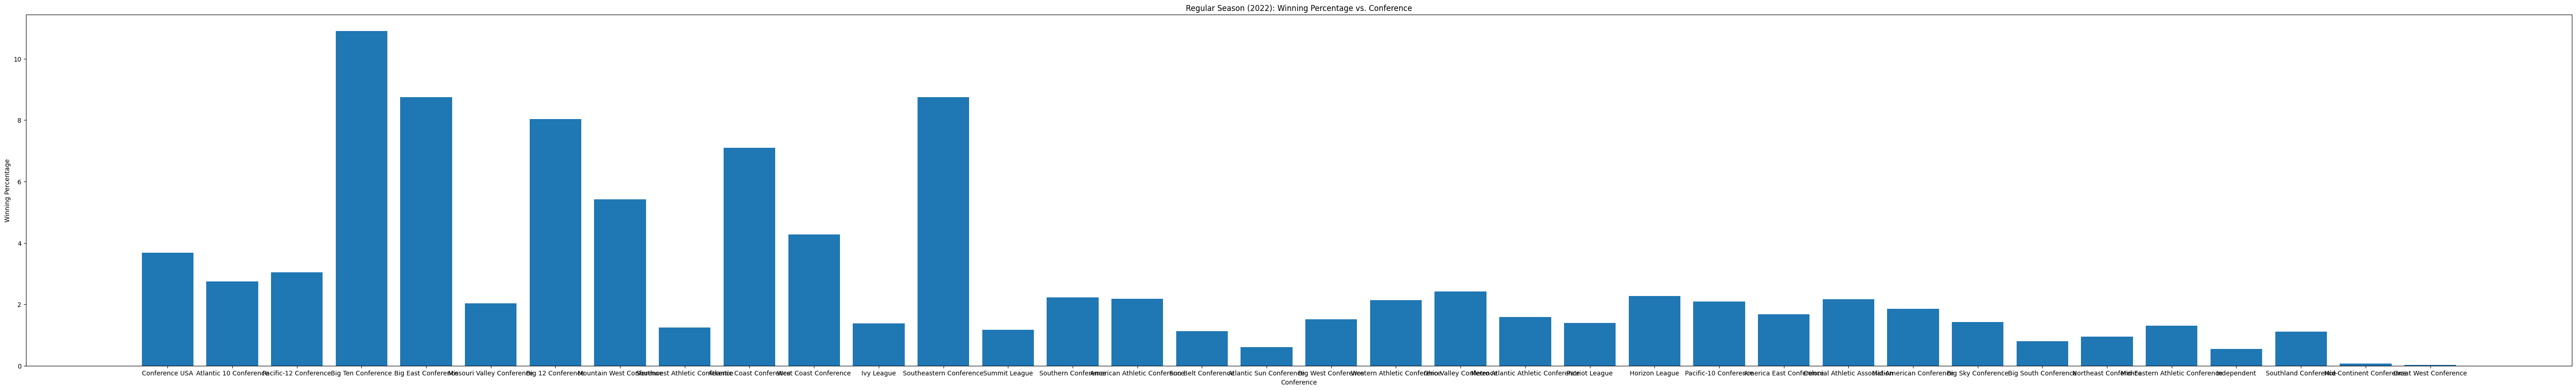

In [148]:
regular_season_winning_conferences_df = regular_season_with_ordinal_ranks_df["WConference"]
regular_conference_freq = {conference : 0 for conference in regular_season_winning_conferences_df}
for conference in regular_season_winning_conferences_df:
    regular_conference_freq[conference] += 1
total_regular_conferences = len(regular_season_winning_conferences_df)
regular_conference_percentage = {conference : round((freq / total_regular_conferences) * 100, 3) for conference, freq in regular_conference_freq.items()}
plt.title("Regular Season (2022): Winning Percentage vs. Conference")
plt.ylabel("Winning Percentage")
plt.xlabel("Conference")
plt.gcf().set_size_inches(72, 10)
plt.bar(regular_conference_percentage.keys(), regular_conference_percentage.values())
plt.show()

In [145]:
plt.savefig("regular_season_conference_winning_percentages.png")

<Figure size 640x480 with 0 Axes>

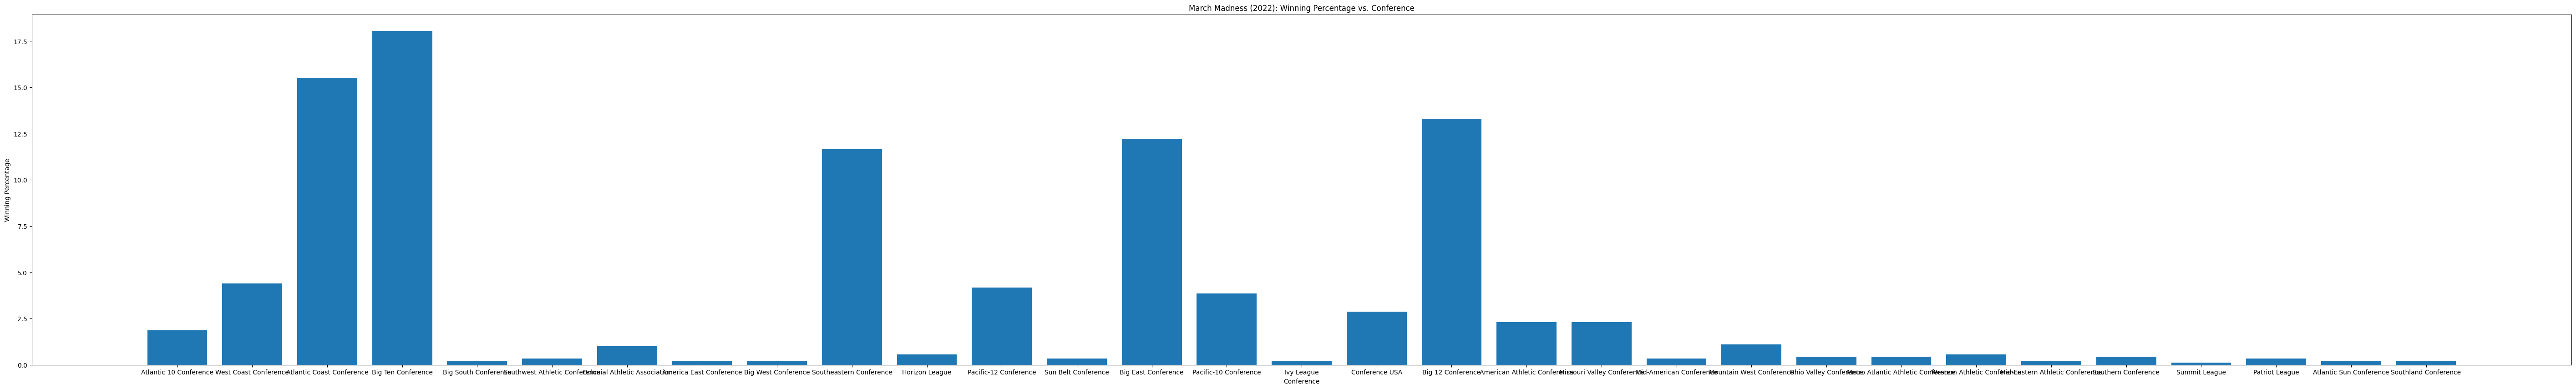

In [149]:
march_madness_winning_conferences = march_madness_with_ordinal_ranks_df["WConference"]
march_conference_freq = {conference : 0 for conference in march_madness_winning_conferences}
for conference in march_madness_winning_conferences:
    march_conference_freq[conference] += 1
total_march_conferences = len(march_madness_winning_conferences)
march_conference_percentage = {conference : round((freq / total_march_conferences) * 100, 3) for conference, freq in march_conference_freq.items()}
plt.title("March Madness (2022): Winning Percentage vs. Conference")
plt.ylabel("Winning Percentage")
plt.xlabel("Conference")
plt.gcf().set_size_inches(72, 10)
plt.bar(march_conference_percentage.keys(), march_conference_percentage.values())
plt.show()

In [143]:
plt.savefig("march_madness_conference_winning_percentages.png")

<Figure size 640x480 with 0 Axes>

What was the conference with the highest winning percentage in the Regular Season of 2022?


In [152]:
highest_winning_percentage_regular_season_2022 = "Big Ten Conference"

What was the conference with the lowest winning percentage in March Madness of 2022?


In [154]:
lowest_winning_percentage_march_madness_2022 = "Summit League"

We saw the notion of seeds earlier, which were rankings made by the NCAA committee prior to March Madness, and while the lower seeds usually win against the higher seeds often times there are huge "upsets" which break millions of brackets. The trickiest part about March Madness, is picking the right upsets. So, let's see just how well seeds do in March Madness. For this, you should create a heatmap, mapping seeds to winning percentage historically throughout March Madness history.

One axis of the heatmap should be the seed of the winning team, and the other axis should be winning percentage, and then the cells of the heatmap should be colored based on the winning percentage of the seed.

Hint: look at matplotlib LinearSegmentedColormap and feel free to use seaborn if you want

Save the heatmap as "march_madness_seed_winning_percentages.png" for submission later on Gradescope.


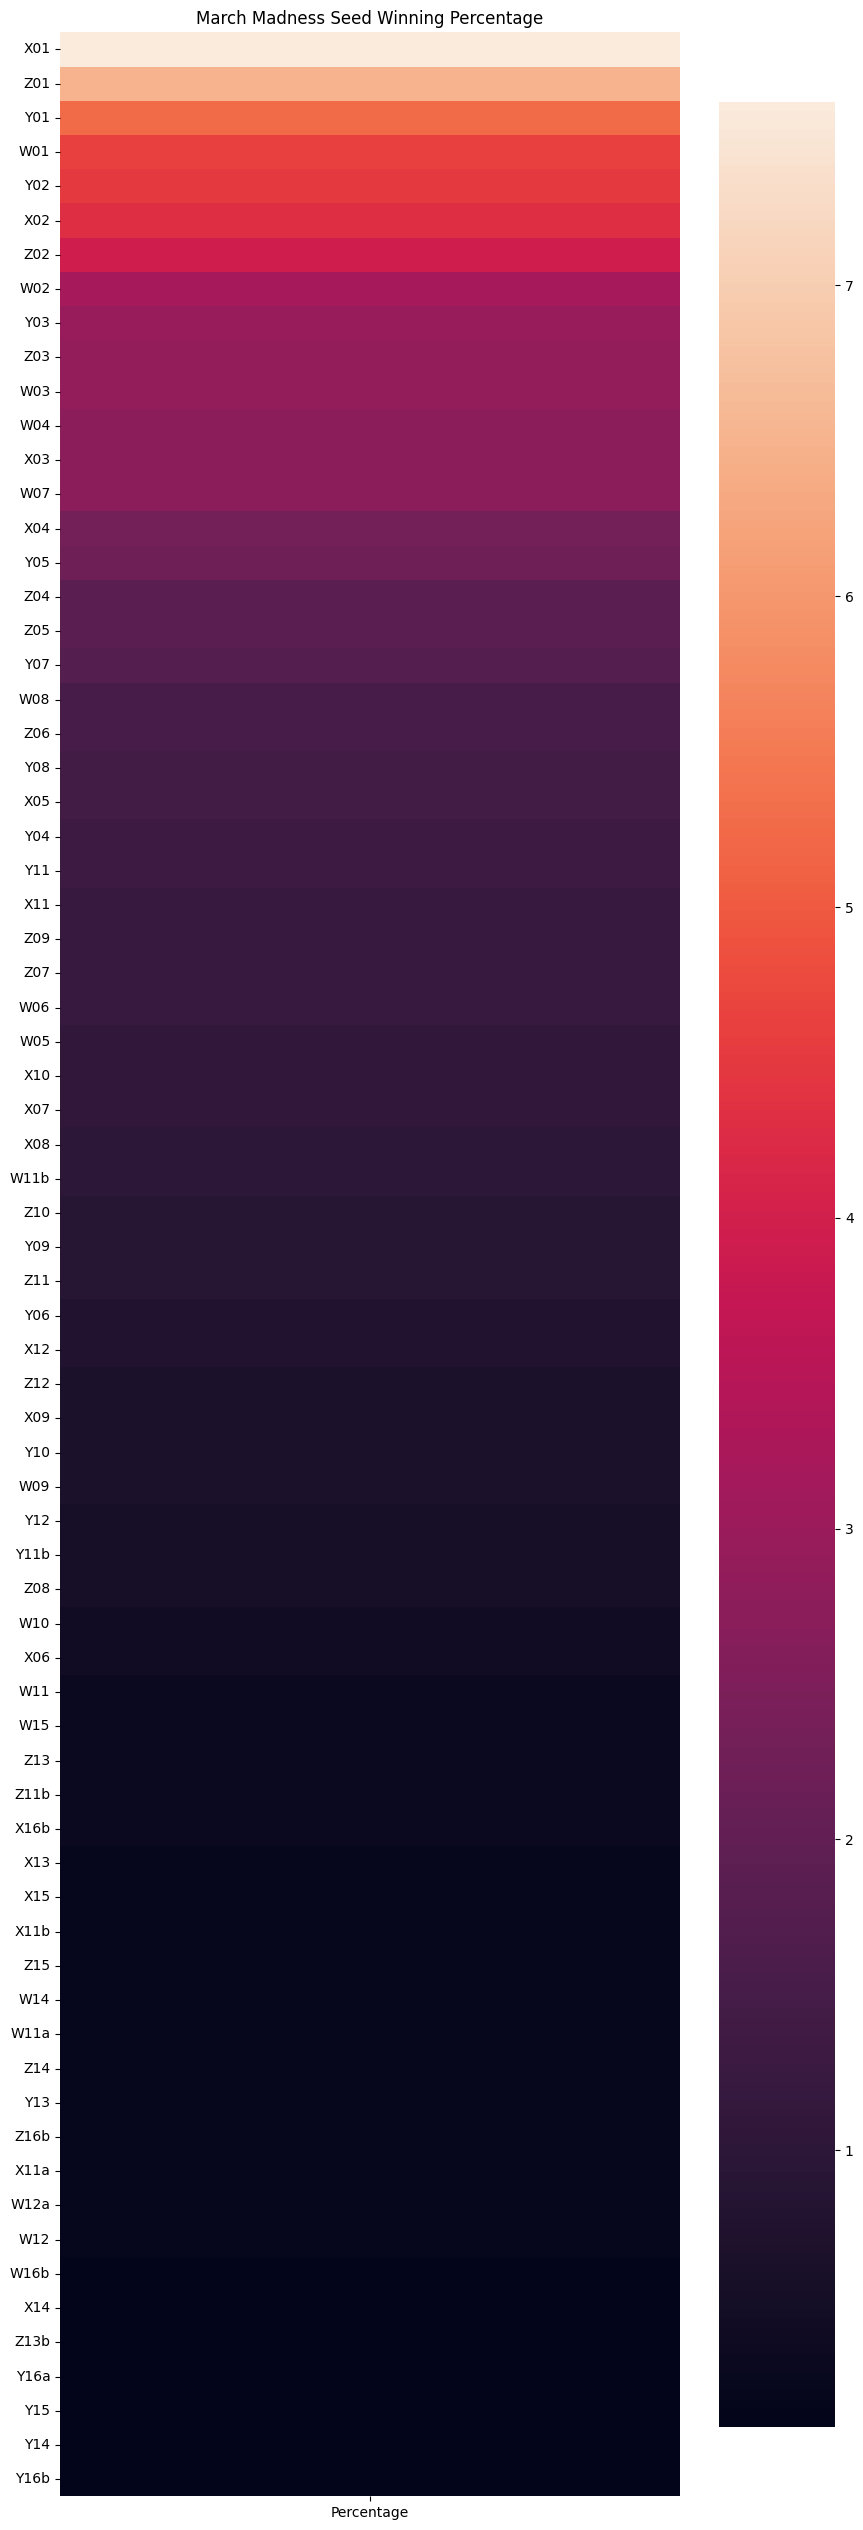

In [150]:
march_winning_seed_df = march_madness_with_ordinal_ranks_df["WSeed"]
march_seed_freq = {seed : 0 for seed in march_winning_seed_df}
for seed in march_winning_seed_df:
    march_seed_freq[seed] += 1
total_march_seeds = len(march_winning_seed_df)
march_seed_percentage = {seed : round((freq / total_march_seeds) * 100, 3) for seed, freq in march_seed_freq.items()}
march_seed_percentage_df =pd.DataFrame.from_dict(march_seed_percentage, orient = "index", columns = ["Percentage"]).sort_values(by = "Percentage", ascending = False)
plt.title("March Madness Seed Winning Percentage")
plt.xlabel("Percentage")
plt.ylabel("Seed")
plt.gcf().set_size_inches(10, 32)
heatmap = sns.heatmap(march_seed_percentage_df)
plt.show()

In [141]:
plt.savefig("march_madness_seed_winning_percentages.png")

<Figure size 640x480 with 0 Axes>

Do you notice anything interesting about the winning percentage by seed? Is there a particular seed that surprises you in terms of their win percentage? **Response in the Markdown below**


**Your Response Here:**
The seed W07 has a pretty high win percentage considering its seed number, since that seed is close to seeds with numbers around 3 and 4. Also, the seed X06 has a pretty low win percentage considering its seed number, since that seed is close to seeds in the double digits.


We also wondered whether certain coaches were better than others for winning purposes. So, create a dotplot, with the y-axis being March Madness Winning Percentage, and the x-axis being Regular Season Winning Percentage and plot all of the coaches on this grid, to see whether certain coaches are better for Regular Season play compared to March Madness play.

Save the dotplot as "coach_winning_percentages.png" for submission later on Gradescope.


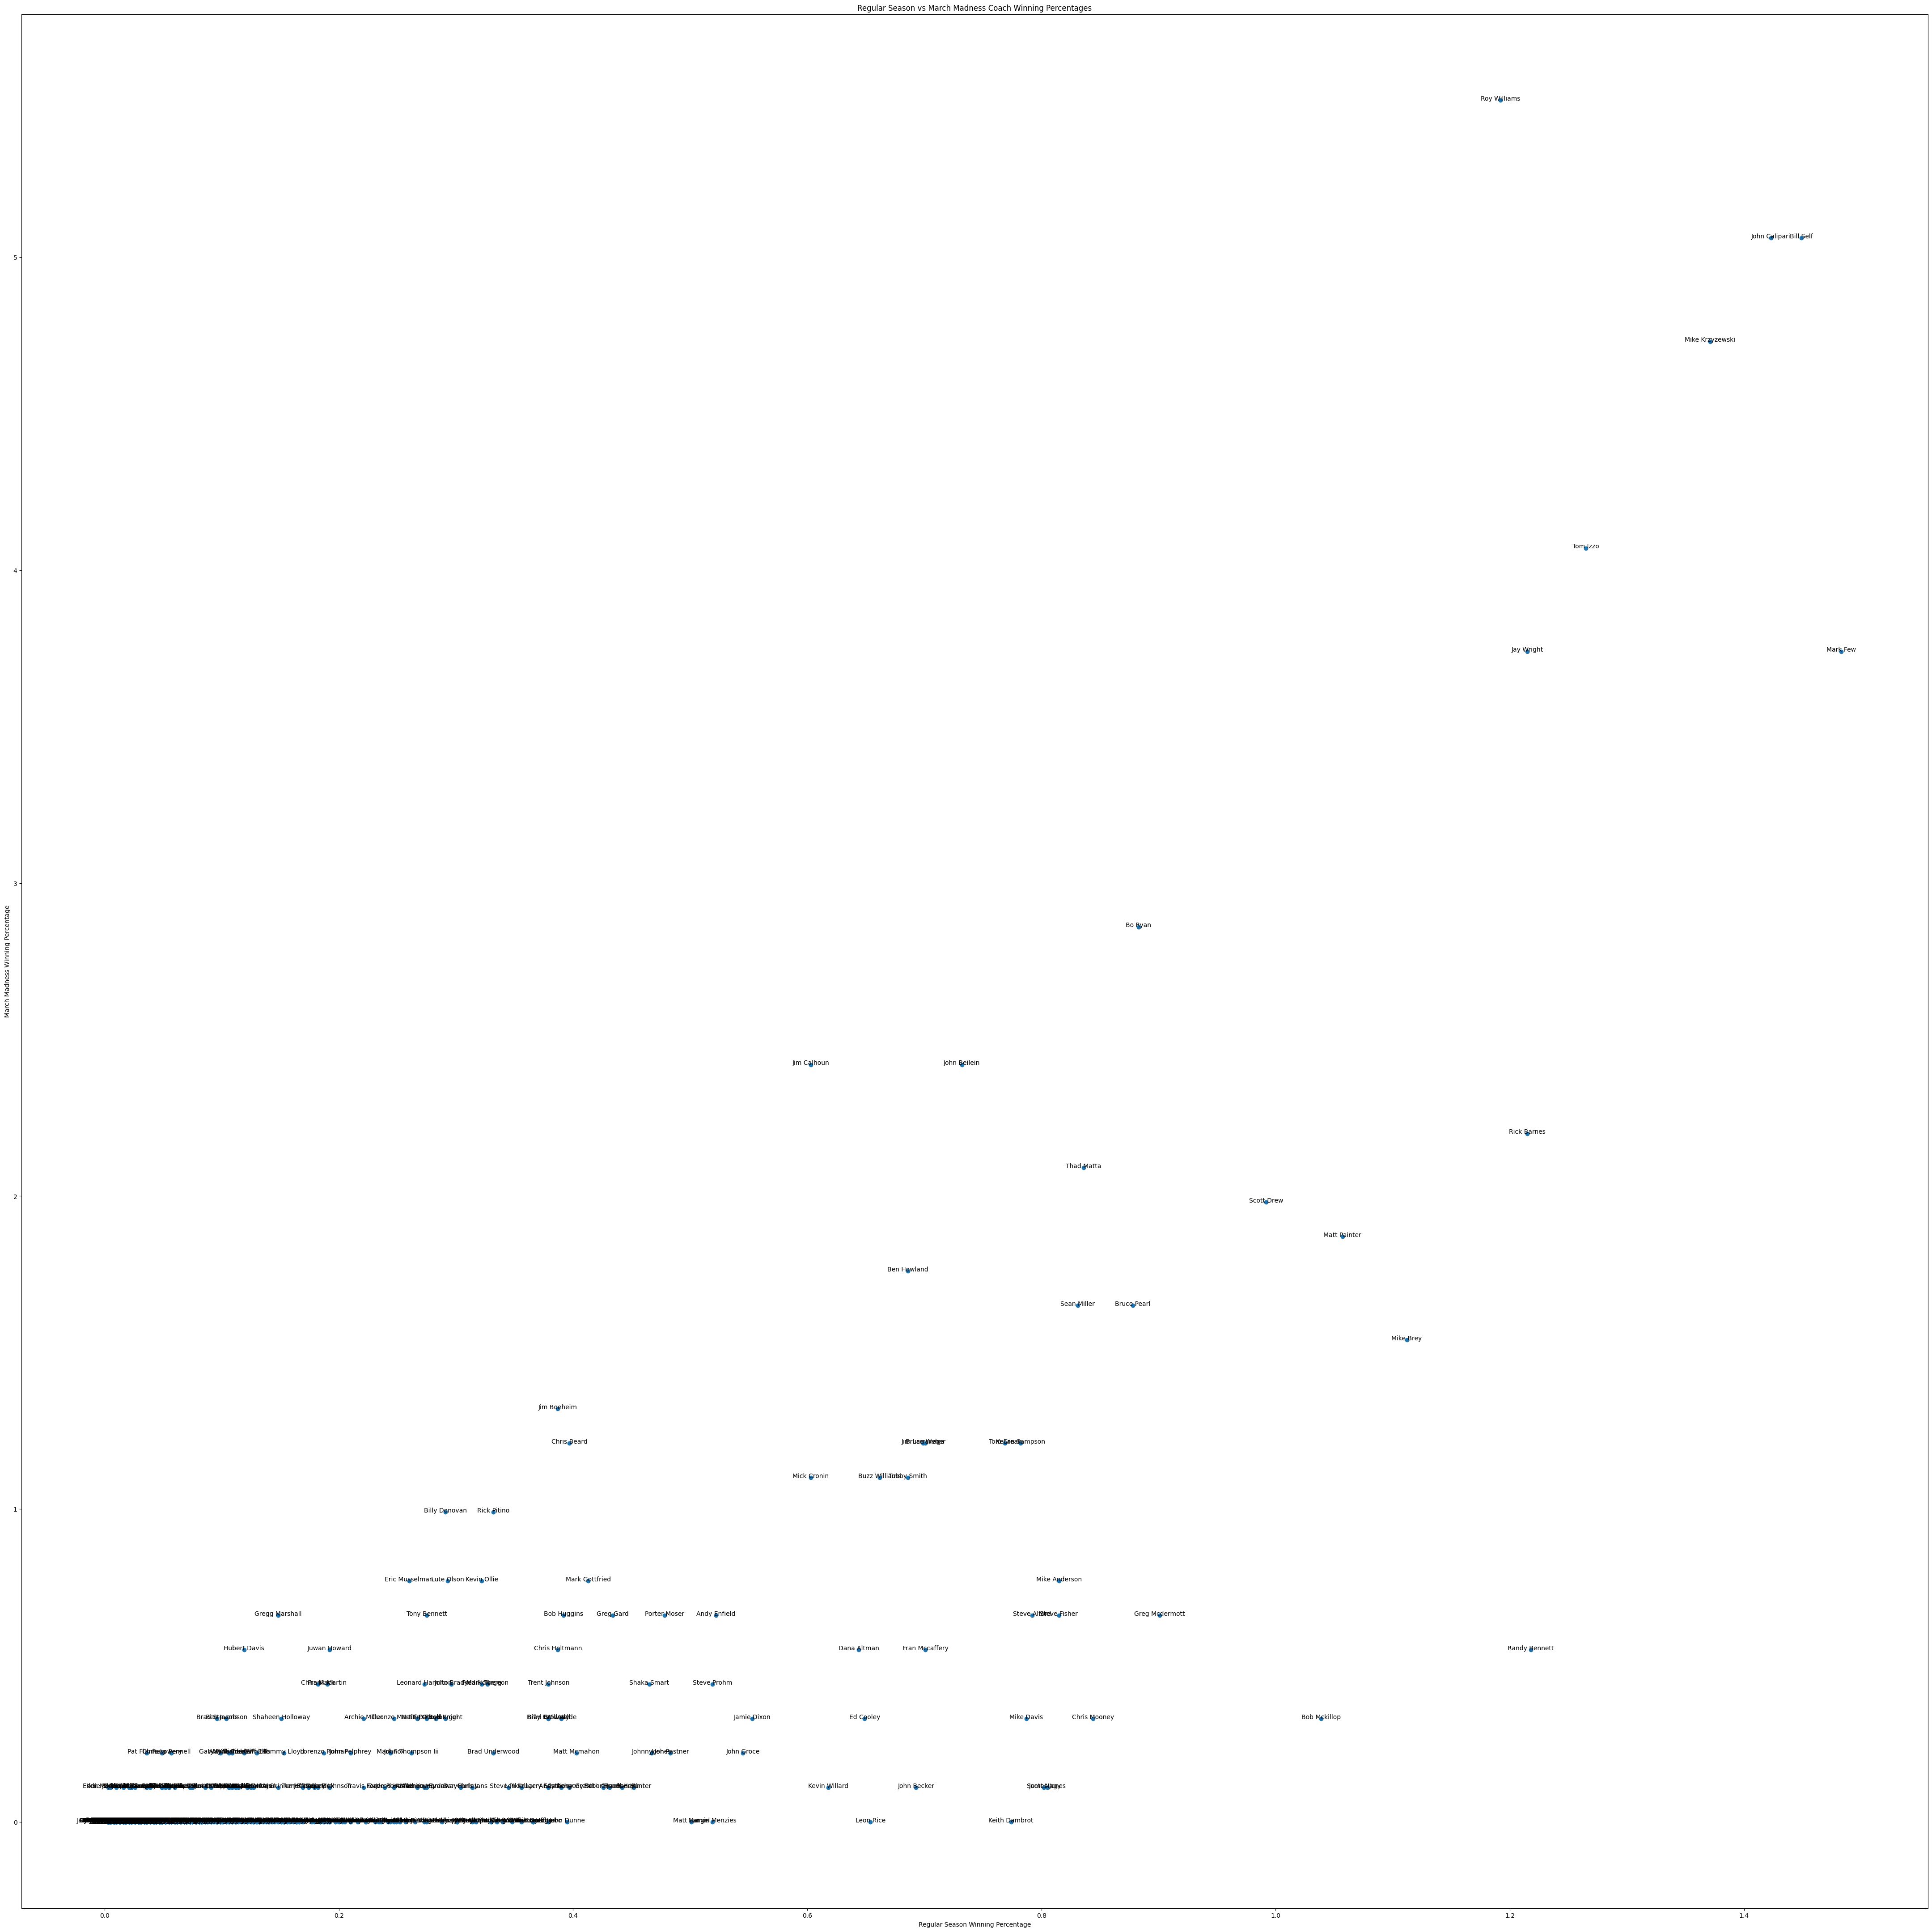

In [686]:
march_madness_winning_coaches = march_madness_with_ordinal_ranks_df["WCoachName"]
march_coach_freq = {coach : 0 for coach in march_madness_winning_coaches}
for coach in march_madness_winning_coaches:
    march_coach_freq[coach] += 1
total_march_coaches = len(march_madness_winning_coaches)
march_coach_percentage = {coach : round((freq / total_march_coaches) * 100, 3) for coach, freq in march_coach_freq.items()}

regular_winning_coaches = regular_season_with_ordinal_ranks_df["WCoachName"]
regular_coach_freq = {coach : 0 for coach in regular_winning_coaches}
for coach in regular_winning_coaches:
    regular_coach_freq[coach] += 1
total_regular_coaches = len(regular_winning_coaches)
regular_coach_percentage = {coach : round((freq / total_regular_coaches) * 100, 3) for coach, freq in regular_coach_freq.items()}

all_winning_coach_percentages = dict()
for coach, percent in march_coach_percentage.items():
    all_winning_coach_percentages[coach] = {"March": percent}
    all_winning_coach_percentages[coach].update({"Regular": 0})
for coach, percent in regular_coach_percentage.items():
    if coach in all_winning_coach_percentages:
        all_winning_coach_percentages[coach]["Regular"] = percent
    else:
        all_winning_coach_percentages[coach] = {"March": 0}
        all_winning_coach_percentages[coach].update({"Regular": percent})

coaches = list(all_winning_coach_percentages.keys())
regular_win_percentages = [all_winning_coach_percentages[coach]["Regular"] for coach in coaches]
march_win_percentages = [all_winning_coach_percentages[coach]["March"] for coach in coaches]

plt.title("Regular Season vs March Madness Coach Winning Percentages")
plt.ylabel("March Madness Winning Percentage")
plt.xlabel("Regular Season Winning Percentage")
plt.gcf().set_size_inches(55, 55)
plt.scatter(regular_win_percentages, march_win_percentages)
for i, coach in enumerate(coaches):
    plt.text(regular_win_percentages[i], march_win_percentages[i], coach, ha='center')
plt.show()

Who are the best coaches for both March Madness and Regular Season play by winning percentage? List as many as you want.


In [ ]:
winning_percentage = ["Roy Williams", "John Calipari", "Bill Self", "Mike Krzyzewski", "Tom Izzo", "Jay Wright", "Mark Few", "Bo Ryan", "Rick Barnes"]

This next exercise is different. The CIS 1920 analyzed the regular season performance (W/L Ratio) versus Winning in March Madness as it can provide valuable insights into how a team's regular season performance translates to success in the NCAA tournament. We used a lineplot and found the average to see how this would correlate over time. Try to recreate this plot, which can be found as output.png in the homework folder. The title must have your name in at the beginning. Example: "Tanay's Regular Season vs. March Madness Winning Percentage." We have it listed below for you to see as well.


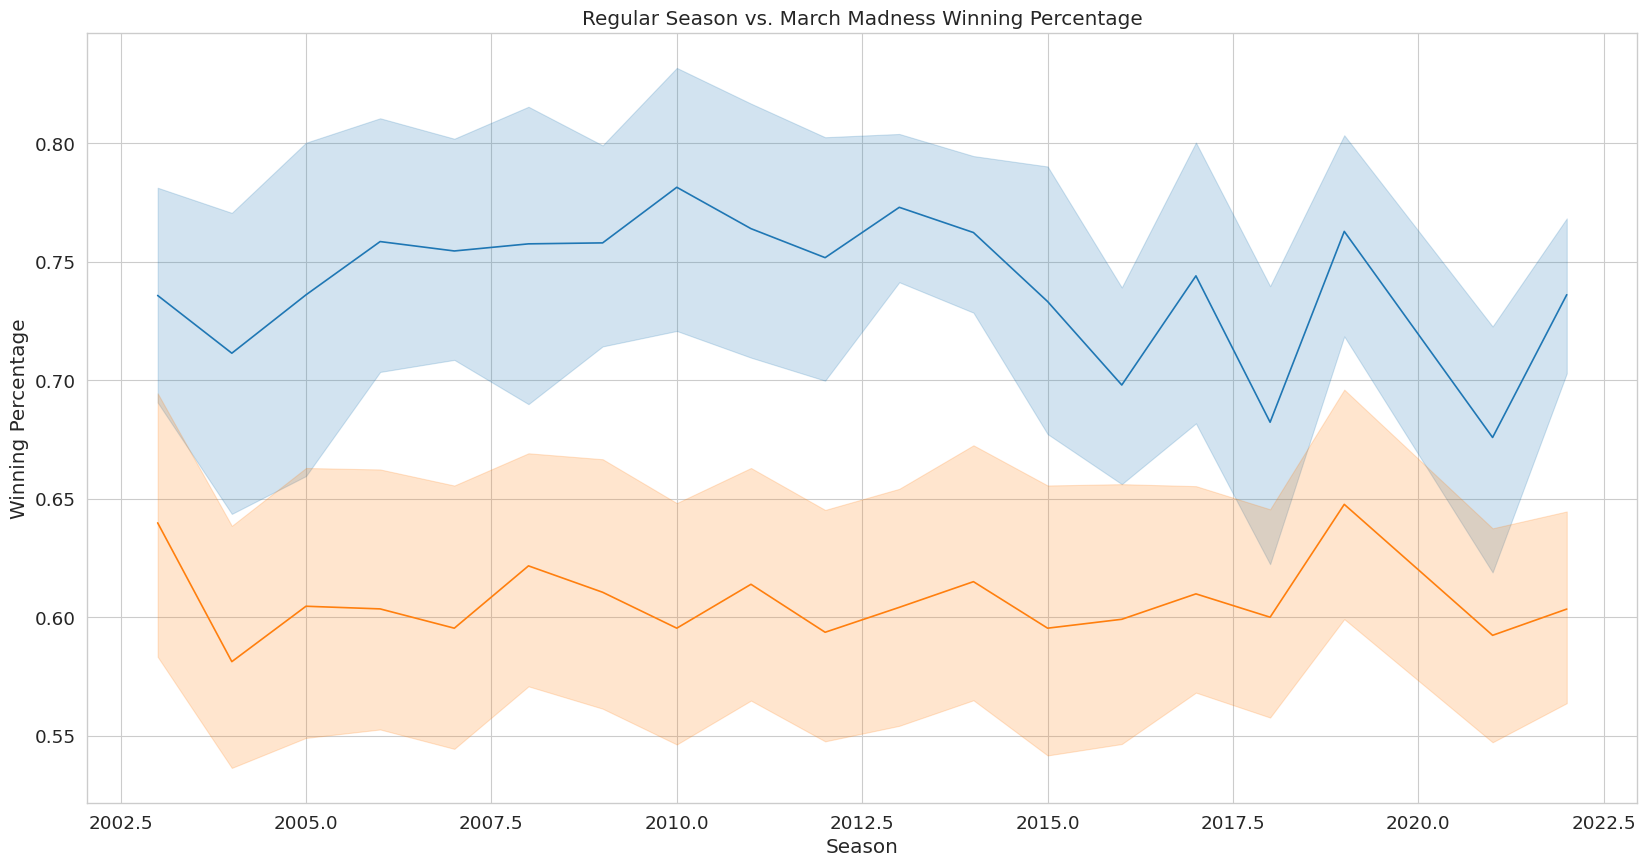


Save the lineplot as "regular_season_vs_march_madness.png" for submission later on Gradescope.


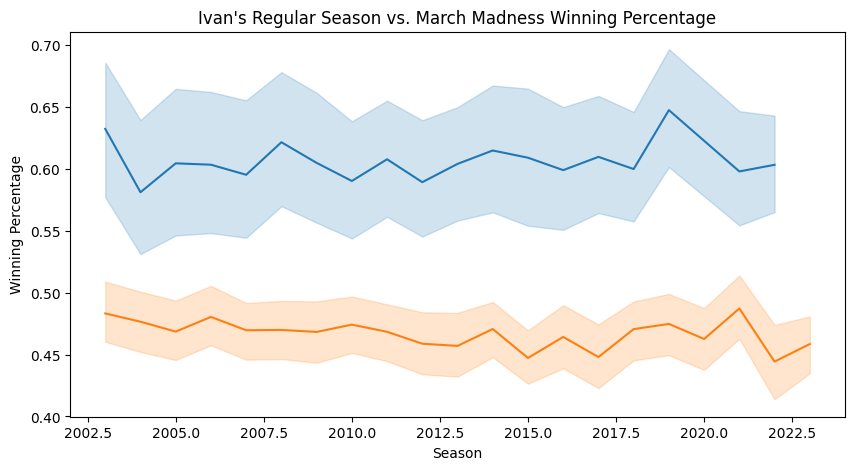

In [687]:
march_madness_winning_teams_and_season = march_madness_with_ordinal_ranks_df[["Season", "WTeamID"]].sort_values(by = ["Season", "WTeamID"])
march_season_and_team_win_count = march_madness_winning_teams_and_season.groupby(["Season", "WTeamID"]).size().reset_index().rename(columns={0 : "Wins"})
march_madness_losing_teams_and_season = march_madness_with_ordinal_ranks_df[["Season", "LTeamID"]].sort_values(by = ["Season", "LTeamID"])
march_season_and_team_loss_count = march_madness_losing_teams_and_season.groupby(["Season", "LTeamID"]).size().reset_index().rename(columns={0 : "Losses"})
march_season_and_team_win_loss_count = pd.merge(march_season_and_team_win_count, march_season_and_team_loss_count, left_on=["Season", "WTeamID"], right_on=["Season", "LTeamID"]) \
                                            .drop("LTeamID", axis = 1) \
                                            .rename(columns = {"WTeamID" : "TeamID"})
march_season_and_team_win_loss_count["Win Percentage"] = march_season_and_team_win_loss_count["Wins"] / (march_season_and_team_win_loss_count["Wins"] + march_season_and_team_win_loss_count["Losses"])

regular_season_winning_teams_and_season = regular_season_with_ordinal_ranks_df[["Season", "WTeamID"]].sort_values(by = ["Season", "WTeamID"])
regular_season_and_team_win_count = regular_season_winning_teams_and_season.groupby(["Season", "WTeamID"]).size().reset_index().rename(columns={0 : "Wins"})
regular_season_losing_teams_and_season = regular_season_with_ordinal_ranks_df[["Season", "LTeamID"]].sort_values(by = ["Season", "LTeamID"])
regular_season_and_team_loss_count = regular_season_losing_teams_and_season.groupby(["Season", "LTeamID"]).size().reset_index().rename(columns={0 : "Losses"})
regular_season_and_team_win_loss_count = pd.merge(regular_season_and_team_win_count, regular_season_and_team_loss_count, left_on=["Season", "WTeamID"], right_on=["Season", "LTeamID"]) \
                                            .drop("LTeamID", axis = 1) \
                                            .rename(columns = {"WTeamID" : "TeamID"})
regular_season_and_team_win_loss_count["Win Percentage"] = regular_season_and_team_win_loss_count["Wins"] / (regular_season_and_team_win_loss_count["Wins"] + regular_season_and_team_win_loss_count["Losses"])

plt.title("Ivan's Regular Season vs. March Madness Winning Percentage")
plt.ylabel("Winning Percentage")
plt.xlabel("Season")
plt.gcf().set_size_inches(10, 5)
sns.lineplot(data = march_season_and_team_win_loss_count, x = "Season", y="Win Percentage")
sns.lineplot(data = regular_season_and_team_win_loss_count, x = "Season", y="Win Percentage")
plt.show()

For the final exercise with matplotlib, explore something you are curious about! It can be anything, just try to relate it back to this analysis somehow, and after you create the plot, highlight any insights you find and how they relate to our overall goal.

Save the plot as "custom_plot.png" for submission later on Gradescope.


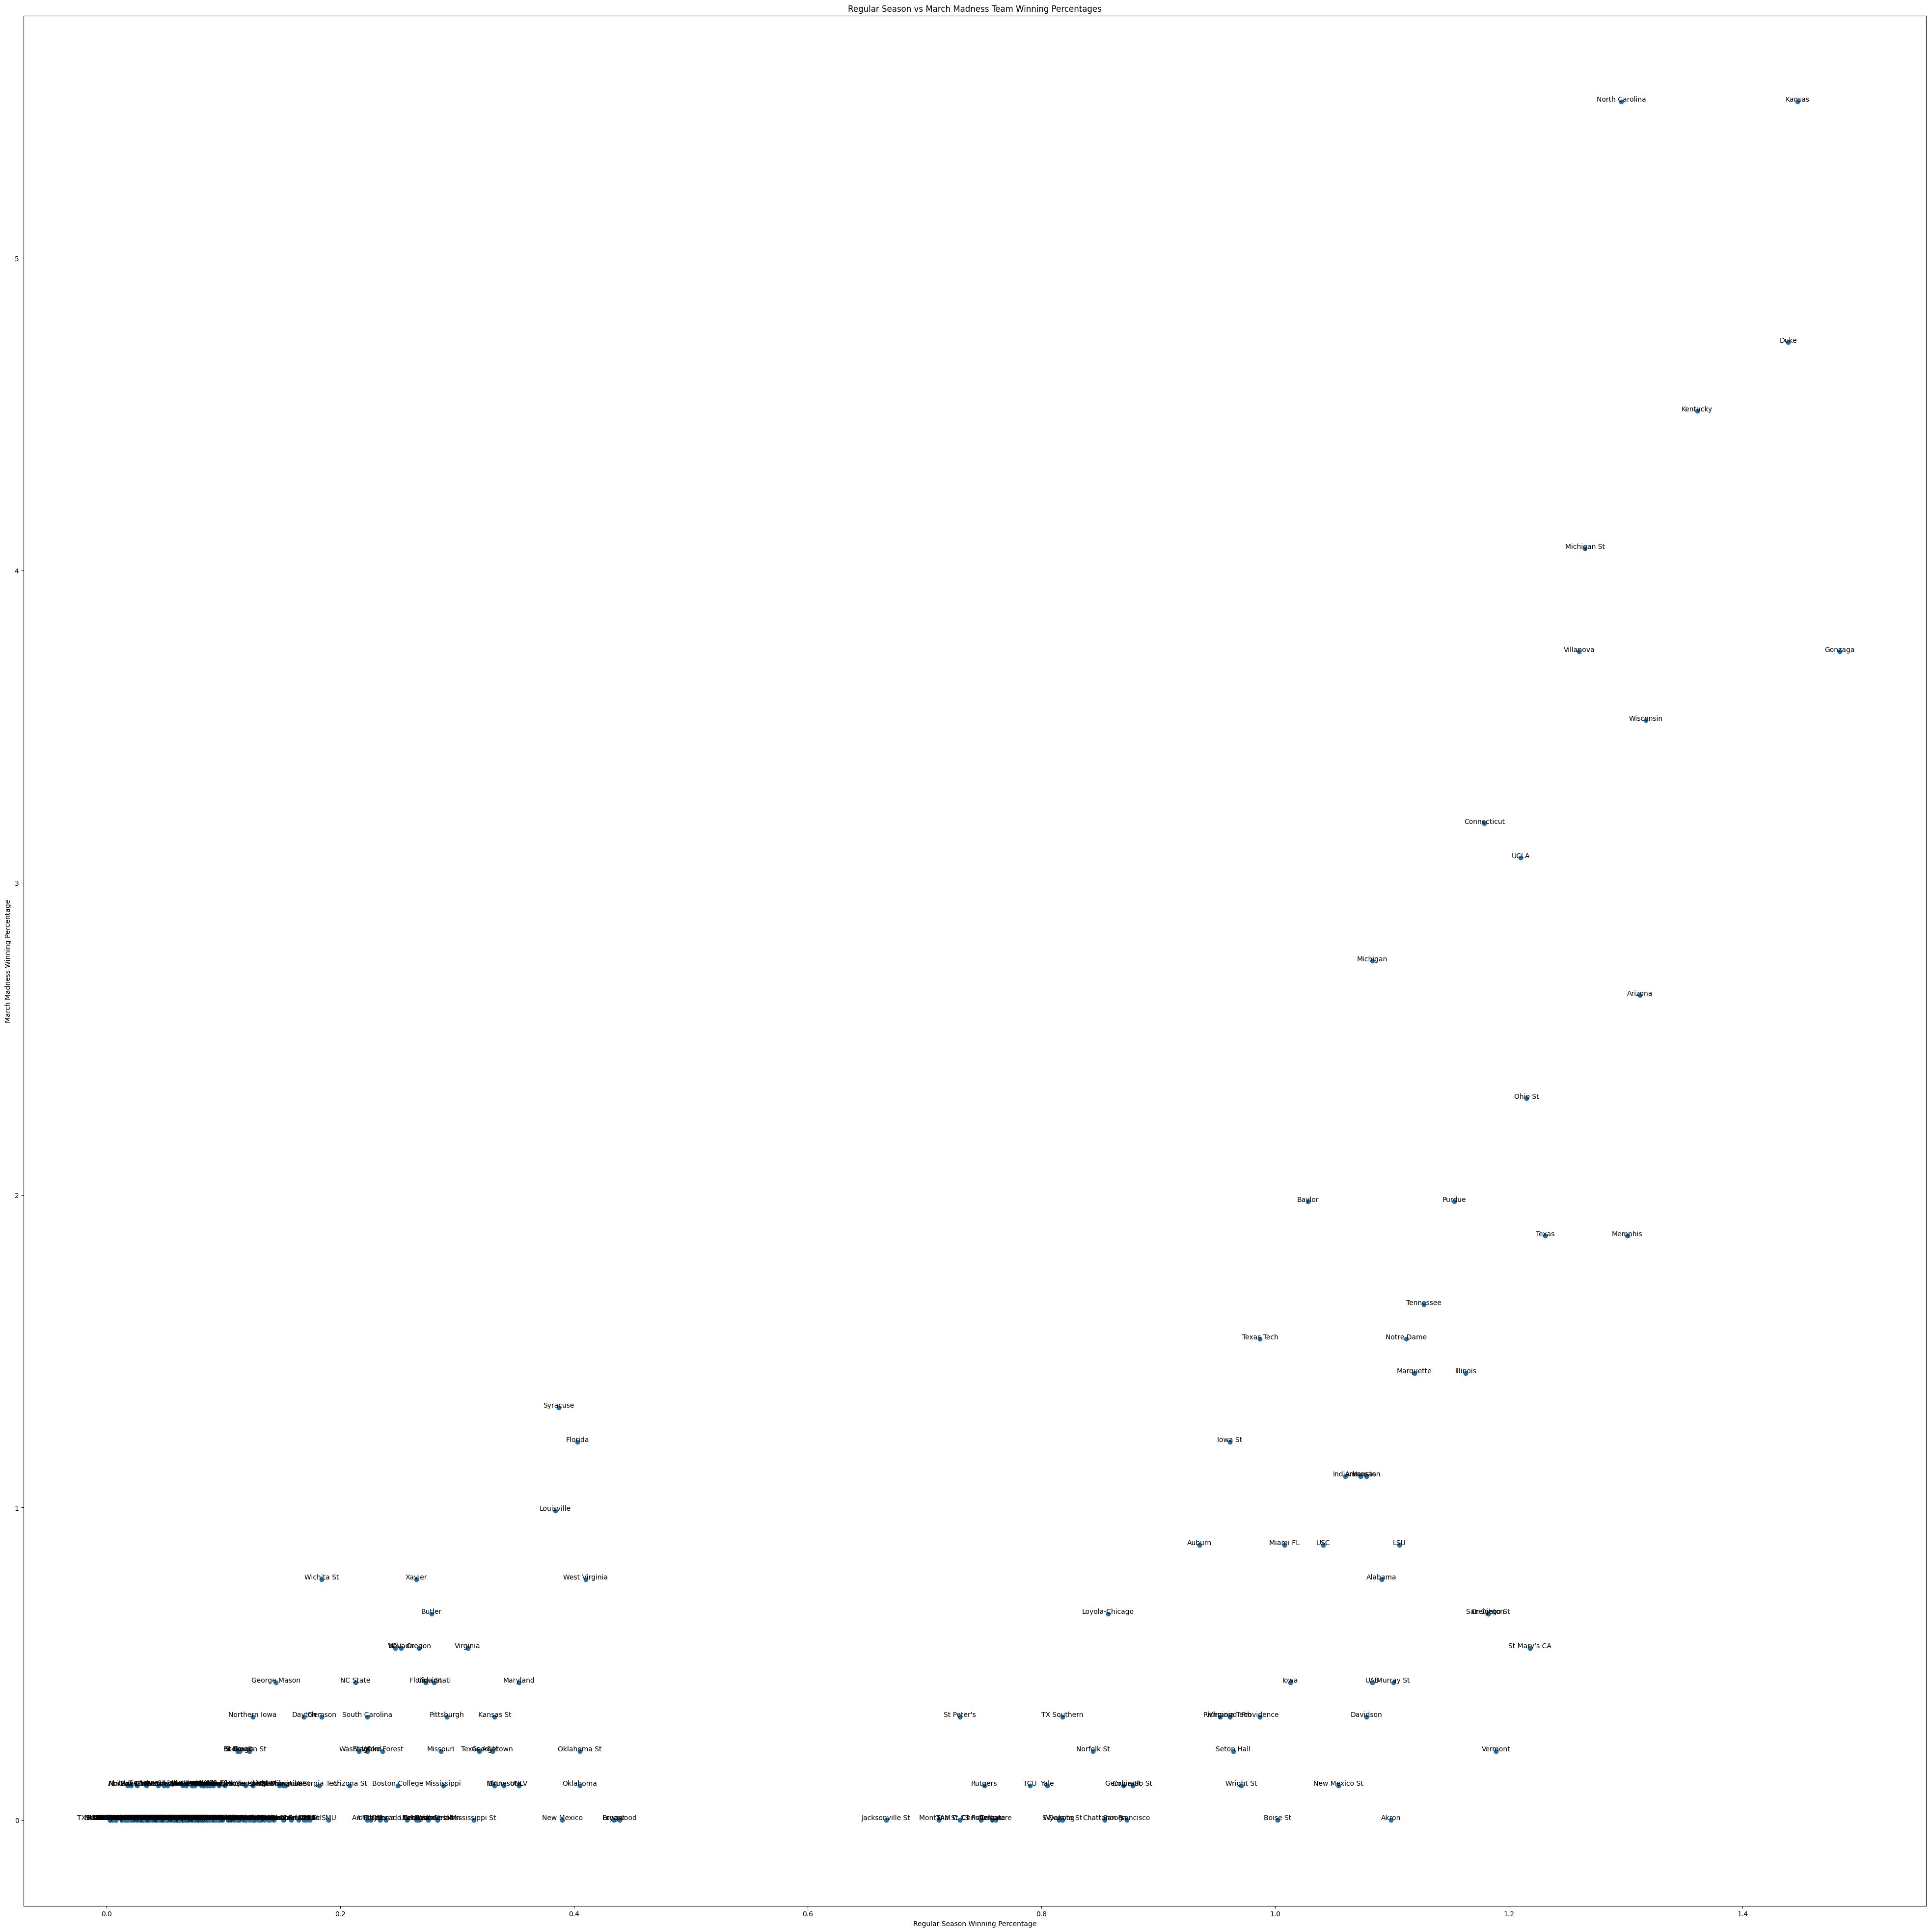

In [200]:
march_madness_winning_teams = march_madness_with_ordinal_ranks_df["WTeamName"]
march_team_freq = {team : 0 for team in march_madness_winning_teams}
for team in march_madness_winning_teams:
    march_team_freq[team] += 1
total_march_teams = len(march_madness_winning_teams)
march_team_percentage = {team : round((freq / total_march_teams) * 100, 3) for team, freq in march_team_freq.items()}

regular_winning_teams = regular_season_with_ordinal_ranks_df["WTeamName"]
regular_team_freq = {team : 0 for team in regular_winning_teams}
for team in regular_winning_teams:
    regular_team_freq[team] += 1
total_regular_teams = len(regular_winning_teams)
regular_team_percentage = {team : round((freq / total_regular_teams) * 100, 3) for team, freq in regular_team_freq.items()}

all_winning_team_percentages = dict()
for team, percent in march_team_percentage.items():
    all_winning_team_percentages[team] = {"March": percent}
    all_winning_team_percentages[team].update({"Regular": 0})
for team, percent in regular_team_percentage.items():
    if team in all_winning_team_percentages:
        all_winning_team_percentages[team]["Regular"] = percent
    else:
        all_winning_team_percentages[team] = {"March": 0}
        all_winning_team_percentages[team].update({"Regular": percent})
teams = list(all_winning_team_percentages.keys())
regular_win_percentages = [all_winning_team_percentages[team]["Regular"] for team in teams]
march_win_percentages = [all_winning_team_percentages[team]["March"] for team in teams]

plt.title("Regular Season vs March Madness Team Winning Percentages")
plt.ylabel("March Madness Winning Percentage")
plt.xlabel("Regular Season Winning Percentage")
plt.gcf().set_size_inches(50, 50)
plt.scatter(regular_win_percentages, march_win_percentages)
for i, team in enumerate(teams):
    plt.text(regular_win_percentages[i], march_win_percentages[i], team, ha='center')
plt.show()

Similar to our plot for the winning coaches, I wanted to create a plot comparing the Regular Season and March Madness winning percentages between teams to see the teams that outshine many of the other teams in both the Regular Season and March Madness. This plot shows us which teams are generally better at winning.

### Insights: 
Teams like "Kansas", "North Carolina", "Duke", "Kentucky", "Michigan ST", "Gonzaga", "Villanova", and "Wisconsin" typically do well and better than most teams in both the Regular Season and March Madness.

# Part 4: Data Standardization and Feature Engineering

In order to to train a model we need to ensure that our training data and test data is standardized, in that both the training data and the test data have the same columns. We also need to ensure that the data is in a format that is easy for the model to understand, so let's do some of that.


Let's start by creating a "Location" column in both datasets, which is the name of the team who is hosting the game. To do this, take a look at the "WLoc" column in the regular_season_with_ordinal_ranks_df and the "WLoc" column in the march_madness_with_ordinal_ranks_df. If the value is "H", then the location is the winning team, if the value is "A", then the location is the losing team, and if the value is "N", then the location is "Neutral".


In [272]:
regular_season_with_location_df = regular_season_with_ordinal_ranks_df.copy()
march_madness_with_location_df = march_madness_with_ordinal_ranks_df.copy()

regular_season_with_location_df['Location'] = "Neutral"
regular_season_with_location_df.loc[regular_season_with_location_df["WLoc"] == "H", "Location"] = regular_season_with_location_df["WTeamName"]
regular_season_with_location_df.loc[regular_season_with_location_df["WLoc"] == "A", "Location"] = regular_season_with_location_df["LTeamName"]
march_madness_with_location_df['Location'] = "Neutral"
march_madness_with_location_df.loc[march_madness_with_location_df["WLoc"] == "H", "Location"] = march_madness_with_location_df["WTeamName"]
march_madness_with_location_df.loc[march_madness_with_location_df["WLoc"] == "A", "Location"] = march_madness_with_location_df["LTeamName"]

# We can also now create a "Winner" column for both of the dataframes and drop some columns that we no longer need
regular_season_with_location_df['Winner'] = regular_season_with_location_df["WTeamID"]
march_madness_with_location_df['Winner'] = march_madness_with_location_df["WTeamID"]

regular_season_with_location_df = regular_season_with_location_df.drop(columns=['WLoc', "NumOT", "WTeamName", "LTeamName", 'WRankingDayNum', 'WSystemName','WFirstDayNum', 'WLastDayNum','WConfAbbrev', 'LRankingDayNum', 'LSystemName','LFirstDayNum', 'LLastDayNum', 'LConfAbbrev'])
march_madness_with_location_df = march_madness_with_location_df.drop(columns=['WLoc', "NumOT", "WTeamName", "LTeamName", 'WRankingDayNum', 'WSystemName','WFirstDayNum', 'WLastDayNum','WConfAbbrev', 'LRankingDayNum', 'LSystemName','LFirstDayNum', 'LLastDayNum', 'LConfAbbrev'])


In [269]:
# Test Case #16
test16_df = regular_season_with_location_df.sort_values(by=['Location', 'Season', 'DayNum']).reset_index(drop=True)
first_row = test16_df.iloc[0]
if first_row['Location'] == 'Abilene Chr':
    print('Test Case #16 Passed')
else:
    print('Test Case #16 Failed')

Test Case #16 Passed


In [270]:
# Test Case #17
test17_df = march_madness_with_location_df.sort_values(by=['Location', 'Season']).reset_index(drop=True)
first_row = test17_df.iloc[0]
if first_row['Location'] == 'Neutral':
    print('Test Case #17 Passed')
else:
    print('Test Case #17 Failed')

Test Case #17 Passed


In [273]:
# Test Case #18
if len(regular_season_with_location_df.columns) == 44 and len(march_madness_with_location_df.columns) == 44:
    print('Test Case #18 Passed')
else:
    print('Test Case #18 Failed')

Test Case #18 Passed


We now notice that there are certain columns that are using categorical variables, so we need to convert these into numerical values. The columns are: 'Location', 'WConference', 'LConference', 'WCoachName', 'LCoachName', 'WSeed', and 'LSeed'.

There are 2 major types of encoding that we can use: Label Encoding and One Hot Encoding. Label Encoding is when we assign a unique integer value to each category, and One Hot Encoding is when we create a new column for each category and assign a 1 or 0 to each column. In this case you will be using Label Encoding to avoid blowing up the size of the dataset. Your new dataset should have the same number of columns as the original dataset, but the values in the columns should be numerical.


In [274]:
cat_columns = ['Location', 'WConference', 'LConference', 'WCoachName', 'LCoachName', 'WSeed', 'LSeed']

# create some sort of conversion, try to use .apply and/or .astype('category')
label_encoder = sklearn.preprocessing.LabelEncoder()
regular_season_with_location_df[cat_columns] = regular_season_with_location_df[cat_columns].apply(label_encoder.fit_transform)
march_madness_with_location_df[cat_columns] = march_madness_with_location_df[cat_columns].apply(label_encoder.fit_transform)

We now notice a quite unique issue. If we pass the data as it is currently into a model, the model can just choose the team that has WScore > LScore and predict that team as the winner. When we are about to predict the result of a game we don't know the score of the game, or any of the statistics of that game yet. So instead of passing in these statistics with each row, we can instead pass in the average statistics of the team for the regular season of that year. For example, if there is a WAst for a game between Duke and North Carolina in 2011 where Duke Won, we will find the average assists per game for Duke in 2011 and input that as WAst, and the average assists per game for North Carolina in 2011 and input that as LAst. To do this, start by creating a new dataframe called statistics_df which contains the average statistics for each team by year. Your dataframe should have the following columns: 'Season', 'TeamId','Score','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF'.


In [554]:
# all_data_df = pd.concat([regular_season_with_location_df, march_madness_with_location_df], ignore_index = True)
winning_statistic_df = regular_season_with_location_df.groupby(["Season", "WTeamID"], as_index= False)[['WScore','WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']].mean() \
                                    .rename(columns={"WTeamID" : "TeamID", 'WScore' : "Score",'WFGM' : "FGM",'WFGA': "FGA",'WFGM3' : "FGM3",'WFGA3': "FGA3",'WFTM':"FTM",'WFTA' : "FTA",'WOR':"OR",'WDR': "DR",'WAst': "Ast",'WTO': "TO",'WStl': "Stl",'WBlk': "Blk",'WPF': "PF"})
statistic_df = regular_season_with_location_df.groupby(["Season", "LTeamID"], as_index= False)[['LScore','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']].mean() \
                                    .rename(columns={"LTeamID" : "TeamID", 'LScore' : "Score",'LFGM' : "FGM",'LFGA': "FGA",'LFGM3' : "FGM3",'LFGA3': "FGA3",'LFTM':"FTM",'LFTA' : "FTA",'LOR':"OR",'LDR': "DR",'LAst': "Ast",'LTO': "TO",'LStl': "Stl",'LBlk': "Blk",'LPF': "PF"})
statistic_df = pd.concat([winning_statistic_df, losing_statistic_df], ignore_index= True).groupby(["Season", "TeamID"], as_index= False)[['Score','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']].mean()

In [555]:
# Test Case #19
test_score = statistic_df[(statistic_df['TeamID'] == 1102) & (statistic_df['Season'] == 2003)]['Score'].values[0]
print(test_score)
if test_score > 55 and test_score < 56:
    print('Test Case #19 Passed')
else:
    print('Test Case #19 Failed')

65.83333333333333
Test Case #19 Failed


Now that we have the average statistics for each team by year, we can merge this with our regular_season_with_location and march_madness_with_location datasets to add the average statistics for each team for that year. Call these new datasets regular_season_with_statistics_df and march_madness_with_statistics_df. These datasets should have the same schema as the original datasets, except columns like LScore and WScore should be replaced with LAvgScore and WAvgScore.


In [378]:
regular_season_with_statistics_df = pd.merge(regular_season_with_location_df, statistic_df, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"]) \
                                        .rename(columns={'Score': "WAvgScore",'FGM': "WAvgFGM",'FGA': "WAvgFGA",'FGM3': "WAvgFGM3",'FGA3': "WAvgFGA3",'FTM': "WAvgFTM",'FTA': "WAvgFTA",'OR': "WAvgOR",'DR':"WAvgDR",'Ast':"WAvgAst",'TO': "WAvgTO",'Stl':"WAvgStl",'Blk':"WAvgBlk",'PF':"WAvgPF"}) \
                                        .drop(columns=["TeamID", 'WScore','WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']) \
                                        .merge(statistic_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                        .rename(columns={'Score': "LAvgScore",'FGM': "LAvgFGM",'FGA': "LAvgFGA",'FGM3': "LAvgFGM3",'FGA3': "LAvgFGA3",'FTM': "LAvgFTM",'FTA': "LAvgFTA",'OR': "LAvgOR",'DR':"LAvgDR",'Ast':"LAvgAst",'TO': "LAvgTO",'Stl':"LAvgStl",'Blk':"LAvgBlk",'PF':"LAvgPF"}) \
                                        .drop(columns=["TeamID", 'LScore','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']) 

march_madness_with_statistics_df = pd.merge(march_madness_with_location_df, statistic_df, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"]) \
                                        .rename(columns={'Score': "WAvgScore",'FGM': "WAvgFGM",'FGA': "WAvgFGA",'FGM3': "WAvgFGM3",'FGA3': "WAvgFGA3",'FTM': "WAvgFTM",'FTA': "WAvgFTA",'OR': "WAvgOR",'DR':"WAvgDR",'Ast':"WAvgAst",'TO': "WAvgTO",'Stl':"WAvgStl",'Blk':"WAvgBlk",'PF':"WAvgPF"}) \
                                        .drop(columns=["TeamID", 'WScore','WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']) \
                                        .merge(statistic_df, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"]) \
                                        .rename(columns={'Score': "LAvgScore",'FGM': "LAvgFGM",'FGA': "LAvgFGA",'FGM3': "LAvgFGM3",'FGA3': "LAvgFGA3",'FTM': "LAvgFTM",'FTA': "LAvgFTA",'OR': "LAvgOR",'DR':"LAvgDR",'Ast':"LAvgAst",'TO': "LAvgTO",'Stl':"LAvgStl",'Blk':"LAvgBlk",'PF':"LAvgPF"}) \
                                        .drop(columns=["TeamID", 'LScore','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']) 


In [379]:
# Test Case #20
if len(regular_season_with_statistics_df.columns) == 44 and len(march_madness_with_statistics_df.columns) == 44:
    print('Test Case #20 Passed')
else:
    print('Test Case #20 Failed')

Test Case #20 Passed


Great, so the last thing we need to engineer is the fact that the model could simply predict WTeamID as the winner every time. To account for this we need to instead create "ATeamID" and "BTeamID" Columns, and subsequently statistics columns named after A and B instead of W and L (example: AScore instead of WScore). Then, we randomly assign WTeamID or LTeamID to ATeamID and BTeamID for each row with a 50% chance to ensure the model can't just predict WTeamID as the winner every time.

Hint: look at np.random.rand

Also, edit the "Winner" column to be 1 if ATeamID is the winner, and 0 if BTeamID is the winner.


In [545]:
w_columns = sorted(regular_season_with_statistics_df.filter(regex="^W").columns.tolist())
w_columns.remove("Winner")
l_columns = sorted(regular_season_with_statistics_df.filter(regex='^L').columns.tolist())
l_columns.remove("Location")

regular_season_random_df = regular_season_with_statistics_df.copy()
regular_season_random_df["ATeamID"] = np.where(np.random.rand(len(regular_season_random_df)) < 0.5, regular_season_random_df["WTeamID"], regular_season_random_df["LTeamID"])
regular_season_random_df["BTeamID"] = np.where(regular_season_random_df["ATeamID"] == regular_season_random_df["WTeamID"], regular_season_random_df["LTeamID"], regular_season_random_df["WTeamID"])
regular_season_random_df["Winner"] = np.where(regular_season_random_df["ATeamID"] == regular_season_random_df["WTeamID"], 1, 0)
for i in range(len(w_columns)):
    w_col = w_columns[i]
    l_col = l_columns[i]
    regular_season_random_df.loc[regular_season_random_df["Winner"] == 0, [w_col, l_col]] = regular_season_random_df.loc[regular_season_random_df["Winner"] == 0, [l_col, w_col]].values
regular_season_random_df = regular_season_random_df.drop(columns=["WTeamID", "LTeamID"], axis=1)
regular_season_random_df.columns = regular_season_random_df.columns.str.replace("^W", "A", regex= True).str.replace("^L", "B", regex= True)
regular_season_random_df = regular_season_random_df.rename(columns={"Ainner": "Winner", "Bocation": "Location"})

march_madness_random_df = march_madness_with_statistics_df.copy()
march_madness_random_df["ATeamID"] = np.where(np.random.rand(len(march_madness_random_df)) < 0.5, march_madness_random_df["WTeamID"], march_madness_random_df["LTeamID"])
march_madness_random_df["BTeamID"] = np.where(march_madness_random_df["ATeamID"] == march_madness_random_df["WTeamID"], march_madness_random_df["LTeamID"], march_madness_random_df["WTeamID"])
march_madness_random_df["Winner"] = np.where(march_madness_random_df["ATeamID"] == march_madness_random_df["WTeamID"], 1, 0)
for i in range(len(w_columns)):
    w_col = w_columns[i]
    l_col = l_columns[i]
    march_madness_random_df.loc[march_madness_random_df["Winner"] == 0, [w_col, l_col]] = march_madness_random_df.loc[march_madness_random_df["Winner"] == 0, [l_col, w_col]].values
march_madness_random_df = march_madness_random_df.drop(columns=["WTeamID", "LTeamID"], axis=1)
march_madness_random_df.columns = march_madness_random_df.columns.str.replace("^W", "A", regex= True).str.replace("^L", "B", regex= True)
march_madness_random_df = march_madness_random_df.rename(columns={"Ainner": "Winner", "Bocation": "Location"})


In [522]:
# Test Case #21
if len(regular_season_random_df['Winner'].unique()) == 2 and len(march_madness_random_df['Winner'].unique()) == 2:
    print('Test Case #21 Passed')
else:
    print('Test Case #21 Failed')

Test Case #21 Passed


We also note that since we are predicting March Madness games for the 2022 season, we can remove all regular season games in 2023 and take March Madness games in 2022 and put them into a seperate dataframe (since this is the data we are trying to predict).


In [546]:
final_regular_season_df = regular_season_random_df[regular_season_random_df["Season"] != 2023]
final_march_madness_df = march_madness_random_df[march_madness_random_df["Season"] != 2022]
march_madness_2022_df = march_madness_random_df[march_madness_random_df["Season"] == 2022]


In [525]:
# Test Case #22
if final_regular_season_df['Season'].max() == 2022 and final_march_madness_df['Season'].max() == 2021 and march_madness_2022_df['Season'].max() == 2022:
    print('Test Case #22 Passed')
else:
    print('Test Case #22 Failed')

Test Case #22 Passed


Amazing, now that we have our datasets standardized and engineered, we are ready to construct our training and testing datasets.


In [547]:
final_regular_season_df['is_regular_season'] = 1
final_march_madness_df['is_regular_season'] = 0
march_madness_2022_df['is_regular_season'] = 0
final_input_df = pd.concat([final_regular_season_df, final_march_madness_df])

# TODO: Remove the winner column from the final_input_df dataframe to create x_train
x_train = final_input_df.drop("Winner", axis = 1)

# TODO: Create y_train from the winner column
y_train = final_input_df["Winner"]

# TODO: Create x_test from the march_madness_2022_df dataframe by removing the winner column
x_test = march_madness_2022_df.drop("Winner", axis = 1)

# TODO: Create y_test from the winner column in the march_madness_2022_df dataframe
y_test = march_madness_2022_df["Winner"]

x_train = x_train.reindex(sorted(x_train.columns), axis=1)
x_test = x_test.reindex(sorted(x_test.columns), axis=1)

C:\Users\ivanz\AppData\Local\Temp\ipykernel_26548\3710979332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_regular_season_df['is_regular_season'] = 1
C:\Users\ivanz\AppData\Local\Temp\ipykernel_26548\3710979332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_march_madness_df['is_regular_season'] = 0
C:\Users\ivanz\AppData\Local\Temp\ipykernel_26548\3710979332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

# Part 5: Model Construction and Selection

Now that we have our training and testing datasets, we can start to construct our model and select the best model for our data.


## Baseline Prediction:

Predictions we can use as a baseline to determine if our model has any caliber is to compare our model to what most bracketmakers do, simply pick the higher seed to win every game. Thus, we are interested in seeing how accurate a model would be that simply picks the higher seed to win each game. Construct a model that predicts the winner of each game as the team with the higher seed and calculate the accuracy of this model


In [548]:
y_pred = np.where(x_test["ASeed"] < x_test["BSeed"], 1, 0)
baseline_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(baseline_accuracy)

0.8235294117647058


In [544]:
# Test Case #23
if baseline_accuracy > 0.8:
    print('Test Case #23 Passed')
else:
    print('Test Case #23 Failed')

Test Case #23 Passed


## Logistic Regression

Now, let's find out if we can do any better than this model. Let's start with a logistic regression model. Construct a logistic regression model using the training dataset and evaluate the accuracy of the model using the testing dataset.


In [561]:
# TODO: Create a logistic regression model
model = LogisticRegression()
# TODO: Fit the logistic regression model
model.fit(x_train, y_train)
# TODO: Use the logistic regression model to predict the y values
predictions = model.predict(x_test)
# TODO: Calculate the accuracy of the logistic regression model

logistic_regression_accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [562]:
# Test Case #24
if logistic_regression_accuracy > 0.6:
    print('Test Case #24 Passed')
else:
    print('Test Case #24 Failed')

Test Case #24 Passed


Let's do something even more sophisticated. Let's run Principal Component Analysis and then a logistic regression model. First, we need to scale the data using StandardScaler.

You may be wondering. What is PCA? PCA is a technique that is used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. It's also used to make models better at predicting.

This may be your first time hearing about PCA, and that's okay! We encourage you to look up PCA and understand it better. In fact, here are some resources to help you understand PCA better and you should definitely look at them before you continue:

#### Documentation

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

#### Tutorial

https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html


In [564]:
scaler = StandardScaler()
# TODO: Fit the scaler to the x_train dataframe
scaler.fit(x_train)
# TODO: Transform the x_train and x_test dataframes using the scaler and save the result to x_train_scaled
r_x_train_scaled = scaler.transform(x_train)
r_x_test_scaled = scaler.transform(x_test)

# TODO: Create a PCA object and fit and transform it to the r_x_train_scaled dataframe
pca = PCA()
pca.fit_transform(r_x_train_scaled)

# Get the explained variance ratio from the pca object and save it to the variable explained_variance_ratio
explained_variance_ratio = pca.explained_variance_ratio_

Next, use matplotlib to create a scree plot to determine the number of principal components to use. You will need to plot cumulative explained variance on the y-axis and the number of principal components on the x-axis. Attach this as "cumulative_variance.png"

Hint: look at np.cumsum


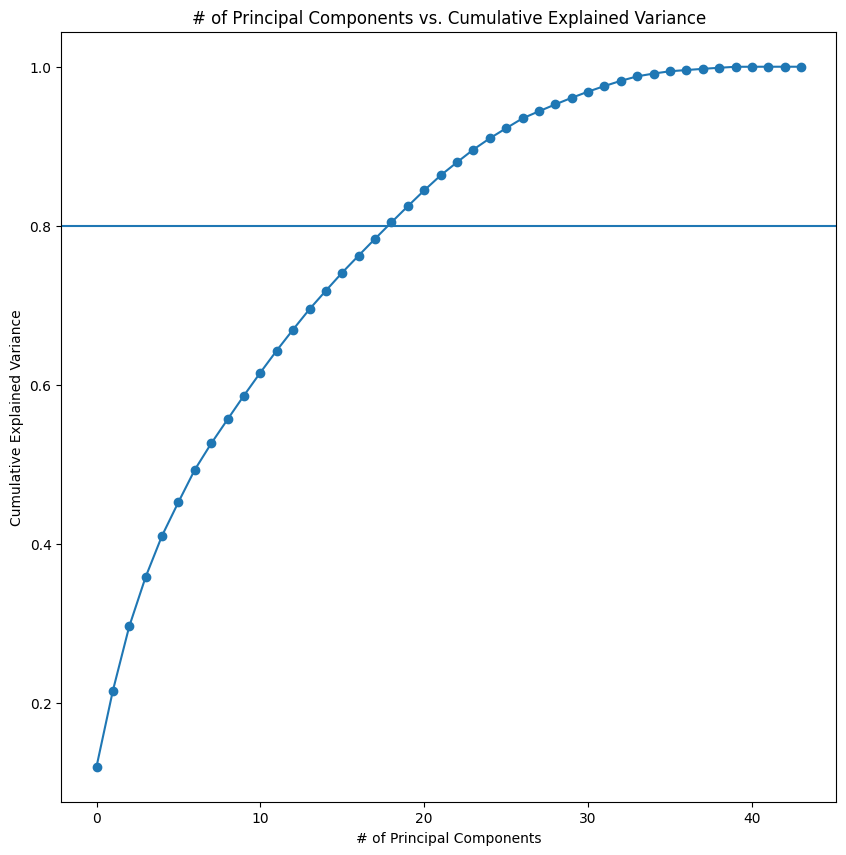

In [577]:
# TODO: Get an array of the cumulative sum of the explained variance ratio and save it to the variable cumulative_explained_variance_ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# TODO: Plot the cumulative_explained_variance_ratio array against the number of components
plt.title("# of Principal Components vs. Cumulative Explained Variance")
plt.ylabel("Cumulative Explained Variance")
plt.xlabel("# of Principal Components")
plt.gcf().set_size_inches(10, 10)
principal_components = np.arange(len(cumulative_explained_variance_ratio))
plt.plot(principal_components, cumulative_explained_variance_ratio, "o-")

# TODO: Draw an axis line at y = 0.8
plt.axhline(y=0.8)
plt.show()
# TODO: Determine the number of principal components that explain 80% of the variance and save it to the variable n_components
n_components = 20

Run PCA with the number of principal components you determined from the scree plot and then run a logistic regression model using the training dataset and evaluate the accuracy of the model using the testing dataset.


In [583]:
pca = PCA(n_components)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

model = LogisticRegression()
model.fit(x_train_pca, y_train)
predictions = model.predict(x_test_pca)

logistic_regression_accuracy_pca = sklearn.metrics.accuracy_score(y_test, predictions)

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [584]:
# Test Case #25
if logistic_regression_accuracy_pca > 0.6:
    print('Test Case #25 Passed')
else:
    print('Test Case #25 Failed')

Test Case #25 Passed


## Random Forest

Now, let's try a more sophisticated model that might be better suited to classification and should in theory at least reach the accuracy made by our baseline model: A Random Forest Classifier.

Play around with the hyperparameters to optimize the model (n_estimators, max_depth, class_weight, etc.)


In [593]:
# TODO: Create a random forest classifier model
forest = RandomForestClassifier()

# TODO: Fit the random forest classifier model
forest.fit(x_train, y_train)

# TODO: Use the random forest classifier model to predict the y values
predictions = forest.predict(x_test)

# TODO: Calculate the accuracy of the random forest classifier model
rf_accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

In [610]:
# Test Case #26
if rf_accuracy > 0.8:
    print('Test Case #26 Passed')
else:
    print('Test Case #26 Failed')

0.8529411764705882
Test Case #26 Passed


Ok, now that we created a random forest model, let's see if we can improve it using ROC Curves and AUC. What is a ROC Curve? A ROC Curve is a graphical representation of the true positive rate (TPR) vs. the false positive rate (FPR) for a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The AUC is the area under the ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds. Before we make the ROC Curve, we will use our random forest model to create a confusion matrix.


In [627]:
# TODO: Create a confusion matrix for the random forest classifier model
conf_maxtrix = confusion_matrix(y_test, predictions)


Now that we have the confusion matrix, let's create the ROC Curve and calculate the AUC. Save your ROC curve as "random_forst_roc_curve.png" for submission later on Gradescope.


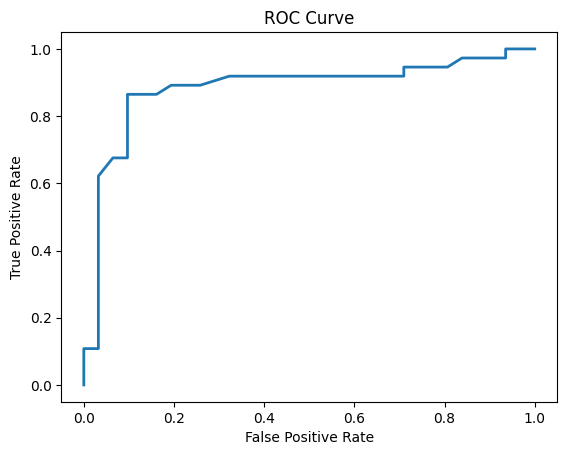

In [603]:
# TODO: create the ROC curve using matplotlib
y_scores = forest.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_scores)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, lw=2)
plt.show()

# TODO: Calculate the AUC for the random forest classifier model
roc_auc = sklearn.metrics.auc(fpr, tpr)

Let's see if we can make any improvements by first using the PCA from earlier and then using a Random Forest on top of that.


In [683]:
pca = PCA()
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

forest = RandomForestClassifier()
forest.fit(x_train_pca, y_train)

predictions = forest.predict(x_test_pca)

rf_accuracy_pca = sklearn.metrics.accuracy_score(y_test, predictions)

In [685]:
# Test Case #27 
if rf_accuracy_pca > 0.85:
    print('Test Case #27 Passed')
else:
    print('Test Case #27 Failed')

0.8088235294117647
Test Case #27 Failed


## Extra Credit: Accuracy Bounty

The CIS 1920 is offering an accuracy bounty for the best model. The model with the highest accuracy will receive a prize (most likely extra credit of some sort). The prize will be awarded to the model with the highest accuracy on the testing dataset. Please don't do anything obviously wrong to get a higher accuracy, as we will be checking the code and the model to ensure that it is a valid model. Things not allowed include: using the testing dataset to do any sort of training, fitting, etc.

Some ideas to get you started might be going through this homework again and trying to engineer more features (like including cities where the game as played, but don't bring in external data that we haven't provided to you), or trying different models (anything in scikit learn is fair game), or even trying to optimize the hyperparameters of the models you have already tried.

Looking forward to seeing what you come up with, and hope you all enjoyed the homework and can now build a better bracket than your friends, and the rest of America! Depending on how much time we have, we may even have a bracket competition in class to see who can build the best bracket using the model they built in this homework.

In order to test your model, create some sort of AUC of the ROC curve to measure the accuracy of your model. Store this in some variable name called **ec_auc_value**


In [681]:
pca = PCA()
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

model = sklearn.neighbors.KNeighborsClassifier()
model.fit(x_train_pca, y_train)

predictions = model.predict(x_test_pca)

rf_accuracy_pca = sklearn.metrics.accuracy_score(y_test, predictions)

y_scores = model.predict_proba(x_test_pca)[:, 1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_scores)


In [682]:
ec_auc_value = sklearn.metrics.auc(fpr, tpr)
print(ec_auc_value)